In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()
api_path_ml_est = os.path.join(cwd, '..', 'tools', 'ml_estimation')
api_path_data = os.path.join(api_path_ml_est, 'data', 'ml-100k', 'u.data')
sys.path.append(api_path_ml_est)
sys.path.append(os.path.join(cwd, '..', 'tools', 'sampling_utils'))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from LoadData_pmf import load_rating_data, spilt_rating_dat
from sklearn.model_selection import train_test_split
from pmf import PMF, PMF_torch
import random
import torch, torch.nn as nn
from functools import partial

from sir_ais_sampling import (sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

In [40]:
pmf = PMF()
pmf.set_params({"num_feat": 10, 
                "epsilon": 10, 
                "_lambda": 0.1, 
                "momentum": 0.8, 
                "maxepoch": 300, 
                "num_batches": 1,
                "batch_size": 100000})
ratings = load_rating_data(api_path_data)
print(len(np.unique(ratings[:, 0])), len(np.unique(ratings[:, 1])), pmf.num_feat)
train, test = train_test_split(ratings, test_size=0.2)  # spilt_rating_dat(ratings)

943 1682 10


In [41]:
train.shape

(80000, 3)

In [42]:
test.shape

(20000, 3)

In [43]:
random_seed = 42
ratings.shape

(100000, 3)

In [142]:
np.random.seed(random_seed)
random.seed(random_seed)
pmf.fit(train, test)

Epoch: 1, Training RMSE: 1.127441, Test RMSE 1.121133
Epoch: 2, Training RMSE: 1.127338, Test RMSE 1.121123
Epoch: 3, Training RMSE: 1.127201, Test RMSE 1.121109
Epoch: 4, Training RMSE: 1.127037, Test RMSE 1.121093
Epoch: 5, Training RMSE: 1.126855, Test RMSE 1.121076
Epoch: 6, Training RMSE: 1.126660, Test RMSE 1.121057
Epoch: 7, Training RMSE: 1.126456, Test RMSE 1.121037
Epoch: 8, Training RMSE: 1.126247, Test RMSE 1.121017
Epoch: 9, Training RMSE: 1.126035, Test RMSE 1.120996
Epoch: 10, Training RMSE: 1.125821, Test RMSE 1.120974
Epoch: 11, Training RMSE: 1.125608, Test RMSE 1.120952
Epoch: 12, Training RMSE: 1.125395, Test RMSE 1.120929
Epoch: 13, Training RMSE: 1.125182, Test RMSE 1.120904
Epoch: 14, Training RMSE: 1.124971, Test RMSE 1.120879
Epoch: 15, Training RMSE: 1.124760, Test RMSE 1.120851
Epoch: 16, Training RMSE: 1.124549, Test RMSE 1.120822
Epoch: 17, Training RMSE: 1.124337, Test RMSE 1.120790
Epoch: 18, Training RMSE: 1.124125, Test RMSE 1.120756
Epoch: 19, Training

Epoch: 150, Training RMSE: 0.841108, Test RMSE 0.943589
Epoch: 151, Training RMSE: 0.839989, Test RMSE 0.943221
Epoch: 152, Training RMSE: 0.838887, Test RMSE 0.942873
Epoch: 153, Training RMSE: 0.837791, Test RMSE 0.942534
Epoch: 154, Training RMSE: 0.836708, Test RMSE 0.942207
Epoch: 155, Training RMSE: 0.835629, Test RMSE 0.941891
Epoch: 156, Training RMSE: 0.834564, Test RMSE 0.941590
Epoch: 157, Training RMSE: 0.833510, Test RMSE 0.941300
Epoch: 158, Training RMSE: 0.832469, Test RMSE 0.941019
Epoch: 159, Training RMSE: 0.831443, Test RMSE 0.940734
Epoch: 160, Training RMSE: 0.830428, Test RMSE 0.940462
Epoch: 161, Training RMSE: 0.829427, Test RMSE 0.940201
Epoch: 162, Training RMSE: 0.828431, Test RMSE 0.939937
Epoch: 163, Training RMSE: 0.827449, Test RMSE 0.939685
Epoch: 164, Training RMSE: 0.826482, Test RMSE 0.939447
Epoch: 165, Training RMSE: 0.825523, Test RMSE 0.939219
Epoch: 166, Training RMSE: 0.824578, Test RMSE 0.939006
Epoch: 167, Training RMSE: 0.823640, Test RMSE 0

Epoch: 297, Training RMSE: 0.755027, Test RMSE 0.937041
Epoch: 298, Training RMSE: 0.754747, Test RMSE 0.937084
Epoch: 299, Training RMSE: 0.754472, Test RMSE 0.937128
Epoch: 300, Training RMSE: 0.754198, Test RMSE 0.937162


ValueError: x and y must have same first dimension, but have shapes (300,) and (0,)

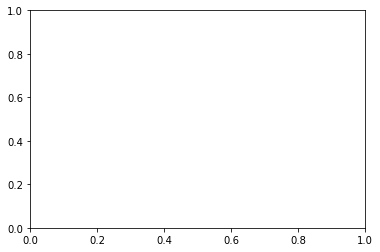

In [47]:
plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
print("precision_acc,recall_acc:" + str(pmf.topK(test)))

In [44]:
class PMF_torch(object):
    def __init__(self, num_feat=10, 
                 epsilon=1, 
                 _lambda=0.1, 
                 momentum=0.8, 
                 maxepoch=20, 
                 num_batches=10, 
                 batch_size=1000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)

        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []

    def loss(self, params, ratings, partition, use_regularize = True, log_prob = False):
        pred_out = torch.sum(torch.multiply(params[:partition],
                                            params[partition:]),
                                     axis=1)  # mean_inv subtracted # np.multiply对应位置元素相乘

        rawErr = pred_out - ratings + self.mean_inv
        
        loss = torch.norm(rawErr) ** 2 
        if use_regularize:
            loss += 0.5 * self._lambda * (torch.norm(params) ** 2)
        if log_prob:
            loss = -loss
        
        return loss
        
    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def fit(self, train_vec, test_vec):
        # mean subtraction
        self.mean_inv = torch.mean(train_vec[:, 2])  # 评分平均值

        pairs_train = train_vec.shape[0]  # traindata 中条目数
        pairs_test = test_vec.shape[0]  # testdata中条目数

        # 1-p-i, 2-m-c
        num_user = int(max(torch.amax(train_vec[:, 0]), torch.amax(test_vec[:, 0]))) + 1  # 第0列，user总数
        num_item = int(max(torch.amax(train_vec[:, 1]), torch.amax(test_vec[:, 1]))) + 1  # 第1列，movie总数

        incremental = False  # 增量
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Item = 0.1 * torch.randn(num_item, self.num_feat)  # numpy.random.randn 电影 M x D 正态分布矩阵
            self.w_User = 0.1 * torch.randn(num_user, self.num_feat)  # numpy.random.randn 用户 N x D 正态分布矩阵

            self.w_Item_inc = torch.zeros((num_item, self.num_feat))  # 创建电影 M x D 0矩阵
            self.w_User_inc = torch.zeros((num_user, self.num_feat))  # 创建用户 N x D 0矩阵

        while self.epoch < self.maxepoch:  # 检查迭代次数
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  # 根据记录数创建等差array
            np.random.shuffle(shuffled_order)  # 用于将一个列表中的元素打乱

            # Batch update
            for batch in range(self.num_batches):  # 每次迭代要使用的数据量
                # print "epoch %d batch %d" % (self.epoch, batch+1)
                
                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # 本次迭代要使用的索引下标

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')
                
                w_User_batch = self.w_User[batch_UserID, :]
                w_Item_batch = self.w_Item[batch_ItemID, :]
                concat_shape = w_User_batch.shape[0]
                
                w_big = torch.cat((w_User_batch.detach(), w_Item_batch.detach())).requires_grad_()

                # Compute gradients
                ratings = train_vec[shuffled_order[batch_idx], 2]
                loss = self.loss(w_big, ratings, concat_shape)
                
                Ix_w_big = torch.autograd.grad(loss, w_big)[0]
                Ix_User = Ix_w_big[:concat_shape]
                Ix_Item = Ix_w_big[concat_shape:]
                
                #Ix_User = 2 * torch.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                #       + self._lambda * self.w_User[batch_UserID, :]
                #Ix_Item = 2 * torch.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                #       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = torch.zeros((num_item, self.num_feat))
                dw_User = torch.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    ratings = train_vec[:, 2]
                    concat_shape = self.w_User[np.array(train_vec[:, 0], dtype='int32'), :].shape[0]
                    w_big = torch.cat((self.w_User[np.array(train_vec[:, 0], dtype='int32'), :], 
                                       self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]))
                    obj = self.loss(w_big, ratings, concat_shape, False).item()
                    obj += 0.5 * self._lambda * (torch.norm(self.w_User) ** 2 + torch.norm(self.w_Item) ** 2)

                    self.rmse_train.append((obj / pairs_train) ** 0.5)

                # Compute validation error
                if batch == self.num_batches - 1:
                    ratings = test_vec[:, 2]
                    concat_shape = self.w_User[np.array(test_vec[:, 0], dtype='int32'), :].shape[0]
                    w_big = torch.cat((self.w_User[np.array(test_vec[:, 0], dtype='int32'), :], 
                                       self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]))
                  
                    loss = self.loss(w_big, ratings, concat_shape, use_regularize = False).item()
                    self.rmse_test.append((loss / pairs_test)** 0.5)

                    # Print info
                    if batch == self.num_batches - 1:
                        print('Epoch: %d, Training RMSE: %f, Test RMSE %f' % (self.epoch,
                                                                              self.rmse_train[-1], 
                                                                              self.rmse_test[-1]))

    def predict(self, invID):
        return (self.w_Item @ self.w_User[int(invID), :]) + self.mean_inv  # numpy.dot 点乘

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv).numpy())[-k:]  # numpy.argsort索引排序

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)

In [45]:
torch_pmf = PMF_torch()
torch_pmf.set_params({"num_feat": 10, 
                      "epsilon": 10, 
                      "_lambda": 0.1, 
                      "momentum": 0.8, 
                      "maxepoch": 300, 
                      "num_batches": 1,
                      "batch_size": 100000})
torch_train = torch.FloatTensor(train)
torch_test = torch.FloatTensor(test)

In [46]:
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch_pmf.fit(torch_train, torch_test)

Epoch: 1, Training RMSE: 1.126533, Test RMSE 1.124365
Epoch: 2, Training RMSE: 1.126426, Test RMSE 1.124359
Epoch: 3, Training RMSE: 1.126284, Test RMSE 1.124353
Epoch: 4, Training RMSE: 1.126112, Test RMSE 1.124341
Epoch: 5, Training RMSE: 1.125922, Test RMSE 1.124330
Epoch: 6, Training RMSE: 1.125716, Test RMSE 1.124317
Epoch: 7, Training RMSE: 1.125502, Test RMSE 1.124304
Epoch: 8, Training RMSE: 1.125280, Test RMSE 1.124286
Epoch: 9, Training RMSE: 1.125055, Test RMSE 1.124270
Epoch: 10, Training RMSE: 1.124827, Test RMSE 1.124253
Epoch: 11, Training RMSE: 1.124598, Test RMSE 1.124234
Epoch: 12, Training RMSE: 1.124369, Test RMSE 1.124210
Epoch: 13, Training RMSE: 1.124139, Test RMSE 1.124189
Epoch: 14, Training RMSE: 1.123906, Test RMSE 1.124157
Epoch: 15, Training RMSE: 1.123674, Test RMSE 1.124126
Epoch: 16, Training RMSE: 1.123438, Test RMSE 1.124090
Epoch: 17, Training RMSE: 1.123202, Test RMSE 1.124050
Epoch: 18, Training RMSE: 1.122961, Test RMSE 1.124004
Epoch: 19, Training

Epoch: 150, Training RMSE: 0.838568, Test RMSE 0.945331
Epoch: 151, Training RMSE: 0.837515, Test RMSE 0.945053
Epoch: 152, Training RMSE: 0.836475, Test RMSE 0.944782
Epoch: 153, Training RMSE: 0.835444, Test RMSE 0.944512
Epoch: 154, Training RMSE: 0.834426, Test RMSE 0.944251
Epoch: 155, Training RMSE: 0.833421, Test RMSE 0.944007
Epoch: 156, Training RMSE: 0.832422, Test RMSE 0.943772
Epoch: 157, Training RMSE: 0.831439, Test RMSE 0.943535
Epoch: 158, Training RMSE: 0.830467, Test RMSE 0.943304
Epoch: 159, Training RMSE: 0.829497, Test RMSE 0.943080
Epoch: 160, Training RMSE: 0.828538, Test RMSE 0.942861
Epoch: 161, Training RMSE: 0.827584, Test RMSE 0.942643
Epoch: 162, Training RMSE: 0.826639, Test RMSE 0.942449
Epoch: 163, Training RMSE: 0.825705, Test RMSE 0.942273
Epoch: 164, Training RMSE: 0.824777, Test RMSE 0.942100
Epoch: 165, Training RMSE: 0.823859, Test RMSE 0.941944
Epoch: 166, Training RMSE: 0.822947, Test RMSE 0.941798
Epoch: 167, Training RMSE: 0.822044, Test RMSE 0

Epoch: 297, Training RMSE: 0.753427, Test RMSE 0.940788
Epoch: 298, Training RMSE: 0.753138, Test RMSE 0.940850
Epoch: 299, Training RMSE: 0.752851, Test RMSE 0.940899
Epoch: 300, Training RMSE: 0.752567, Test RMSE 0.940943


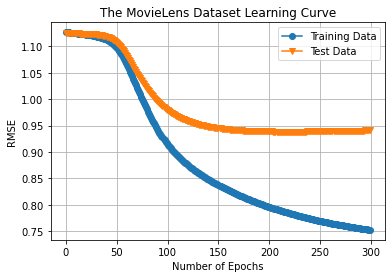

precision_acc,recall_acc:(0.048510638297872555, 0.025632800405455444)


In [48]:
plt.plot(range(torch_pmf.maxepoch), torch_pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(torch_pmf.maxepoch), torch_pmf.rmse_test, marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
print("precision_acc,recall_acc:" + str(torch_pmf.topK(test)))

In [49]:
def compute_sir_log_weights(x, target, proposal):
    return target.log_prob(x) -  proposal.log_prob(x)

def sir_correlated_dynamics_pmf(z, target, proposal, n_steps, N, alpha, partition, train_vec, test_vec):
    z_sp = []
    batch_size, z_dim = z.shape[0], z.shape[1]
    rmse_train = []
    rmse_test = []
    
    for _ in range(n_steps):
        z_sp.append(z)
        z_copy = z.unsqueeze(1).repeat(1, N, 1)
        ind = torch.randint(0, N, (batch_size,)).tolist()
        W = proposal.sample([batch_size, N])
        U = proposal.sample([batch_size]).unsqueeze(1).repeat(1, N, 1)
        #print(W.shape, U.shape, z_copy.shape)
        X = torch.zeros((batch_size, N, z_dim), dtype = z.dtype).to(z.device)
        X =  (alpha**2)*z_copy + alpha*((1- alpha**2)**0.5)*U + W*((1- alpha**2)**0.5)
        X[np.arange(batch_size), ind, :] = z
        X_view = X.view(-1, z_dim)

        log_weight = compute_sir_log_weights(X_view, target, proposal)
        log_weight = log_weight.view(batch_size, N)
        max_logs = torch.max(log_weight, dim = 1)[0][:, None]
        log_weight = log_weight - max_logs
        weight = torch.exp(log_weight)
        sum_weight = torch.sum(weight, dim = 1)
        weight = weight/sum_weight[:, None]        

        weight[weight != weight] = 0.
        weight[weight.sum(1) == 0.] = 1.

        indices = torch.multinomial(weight, 1).squeeze().tolist()

        z = X[np.arange(batch_size), indices, :]
        z = z.data
        
        target.w_User = z[:partition]
        target.w_Item = z[partition:]
        
        ratings = train_vec[:, 2]
        concat_shape = target.w_User[np.array(train_vec[:, 0], dtype='int32'), :].shape[0]
        w_big = torch.cat((target.w_User[np.array(train_vec[:, 0], dtype='int32'), :], 
                           target.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]))
        obj = target.loss(w_big, ratings, concat_shape, False).item()
        obj += 0.5 * self._lambda * (torch.norm(target.w_User) ** 2 + torch.norm(target.w_Item) ** 2)

        rmse_train.append((obj / pairs_train) ** 0.5)
        
        ratings = test_vec[:, 2]
        concat_shape = target.w_User[np.array(test_vec[:, 0], dtype='int32'), :].shape[0]
        w_big = torch.cat((target.w_User[np.array(test_vec[:, 0], dtype='int32'), :], 
                           target.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]))

        loss = target.loss(w_big, ratings, concat_shape, use_regularize = False).item()
        rmse_test.append((loss / pairs_test)** 0.5)

        print('Iter: %d, Training RMSE: %f, Test RMSE %f' % (_,
                                                             rmse_train[-1], 
                                                             rmse_test[-1]))
        
    z_sp.append(z)
    return z_sp, rmse_train, rmse_test

In [50]:
device = 'cpu'
scale_proposal = 0.1
proposal = init_independent_normal(scale_proposal, torch_pmf.num_feat, device)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
c = 1.0
N = 10
n_steps = 20
alpha = (1 - c/torch_pmf.num_feat)**0.5

target = torch_pmf
ratings = torch_train[:, 2]
concat_shape = torch_pmf.w_User.shape[0]
num_items = torch_pmf.w_Item.shape[0]

In [52]:
concat_shape, num_items

(944, 1683)

In [53]:
target.log_prob = partial(target.loss, 
                          ratings = ratings, 
                          partition = concat_shape, 
                          use_regularize = True, 
                          log_prob = True)

start = proposal.sample([concat_shape + num_items])
history, rmse_train, rmse_test = sir_correlated_dynamics_pmf(start, 
                                                             target,
                                                             proposal, 
                                                             n_steps, 
                                                             N,
                                                             alpha,
                                                             concat_shape, 
                                                             torch_train, 
                                                             torch_test)

RuntimeError: The size of tensor a (944) must match the size of tensor b (25326) at non-singleton dimension 0